In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
from ast import literal_eval
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev,opt_prob_metrics_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

from obspy import read,Stream,Trace
from obspy.signal.trigger import ar_pick, pk_baer

In [2]:
cm = 1 / 2.54
fts = 8

# Load model

In [91]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)

org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt2 = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_eqt2.cuda()
org_pn.cuda()
print("org_eqt")
print(org_eqt.labels)
print(org_eqt.component_order)
print(org_eqt.norm)
print(org_eqt.device)
print()

print("org_pn")
print(org_pn.labels)
print(org_pn.component_order)
print(org_pn.norm)
print(org_pn.device)
print()

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0
org_eqt
['Detection', 'P', 'S']
ZNE
std
cuda:0

org_pn
NPS
ENZ
std
cuda:0



True
Min val_loss: 361, 0.042899839580059
Min train_loss: 158.0, 0.0417405441403389
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/p/version_0
True
Min val_loss: 474, 0.0157630927860736
Min train_loss: 440.0, 0.016658766195178
/home/zhongyiyuan/volpick/model_training/weights_wholedataset/e/version_0


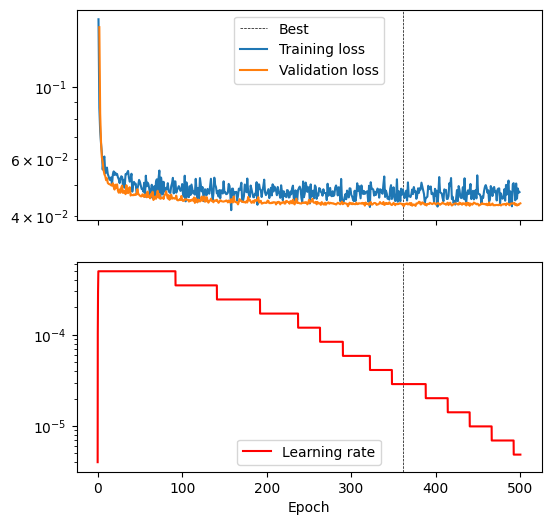

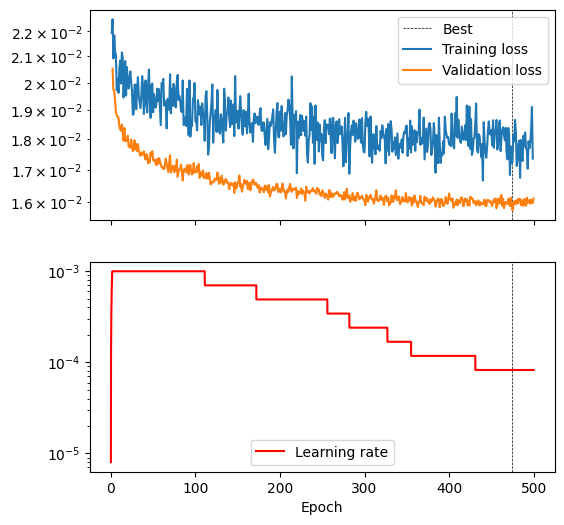

In [61]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_wholedataset")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

# for model_dirname in model_dirs:
#     model_path = models_root_path / model_dirname
vol_pn_whole = load_best_model_from_base_dir(
    models_root_path / "p",
    plot_val_loss=True,
)
vol_pn_whole = vol_pn_whole.model

vol_eqt_whole = load_best_model_from_base_dir(
    models_root_path / "e",
    plot_val_loss=True,
)
vol_eqt_whole = vol_eqt_whole.model

True
Min val_loss: 347, 0.0439251214265823
Min train_loss: 197, 0.0414151847362518
/home/zhongyiyuan/volpick/model_training/weights_wholedataset_try/p/version_0
True
Min val_loss: 389, 0.0159755479544401
Min train_loss: 327, 0.0166283622384071
/home/zhongyiyuan/volpick/model_training/weights_wholedataset_try/e/version_0


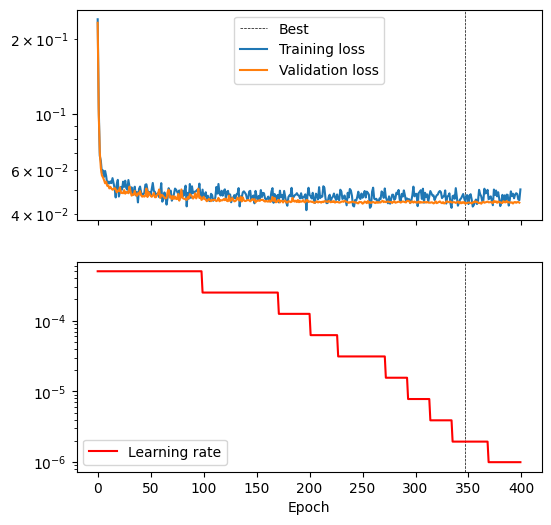

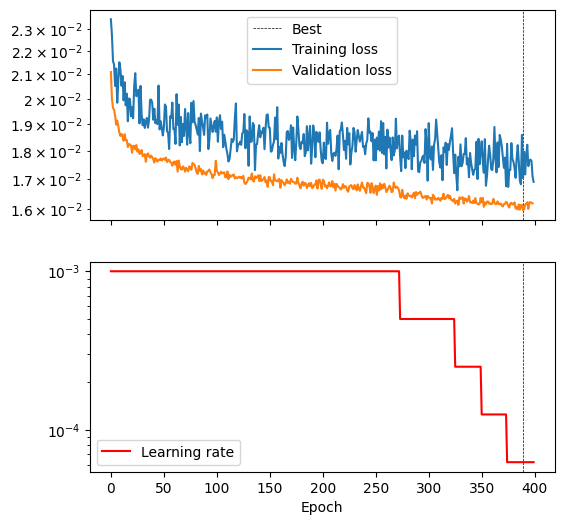

In [31]:
models_root_path = Path(
    "/home/zhongyiyuan/volpick/model_training/weights_wholedataset_try"
)
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

# for model_dirname in model_dirs:
#     model_path = models_root_path / model_dirname
vol_pn_whole = load_best_model_from_base_dir(
    models_root_path / "p", monitor="val_loss", last=False
)
vol_pn_whole = vol_pn_whole.model

vol_eqt_whole = load_best_model_from_base_dir(
    models_root_path / "e", monitor="val_loss", last=False
)
vol_eqt_whole = vol_eqt_whole.model

# Load data

In [37]:
data_path_alaska = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/alaska_onephase")

dataset_alaska = sbd.WaveformDataset(
    data_path_alaska,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset_alaska._metadata["split"] = "test"
print(len(dataset_alaska))
# dataset_alaska.filter(dataset_alaska["split"].isin(["test"]), inplace=True)
# print(len(dataset_alaska))

23042


In [38]:
dataset_alaska_lp = dataset_alaska.filter(
    (dataset_alaska.metadata["source_type"] == "lp")
    | (dataset_alaska.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_alaska_vt = dataset_alaska.filter(
    (dataset_alaska.metadata["source_type"] != "lp")
    | (dataset_alaska.metadata["source_type"] == "noise"),
    inplace=False,
)
print(len(dataset_alaska_lp))
print(len(dataset_alaska_vt))

11526
11516


In [39]:
print(
    len(
        dataset_alaska_lp.metadata[
            pd.notna(dataset_alaska_lp.metadata["trace_p_arrival_time"])
        ]
    )
)
print(
    len(
        dataset_alaska_lp.metadata[
            pd.notna(dataset_alaska_lp.metadata["trace_s_arrival_time"])
        ]
    )
)

5779
5747


In [41]:
data_path_alaska = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/alaska_onephase")

dataset_alaska_ENZ = sbd.WaveformDataset(
    data_path_alaska,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_alaska_ENZ))
dataset_alaska_ENZ._metadata["split"] = "test"
# dataset_alaska_ENZ.filter(dataset_alaska_ENZ["split"].isin(["test"]), inplace=True)
print(len(dataset_alaska_ENZ))
dataset_alaska_ENZ_lp = dataset_alaska_ENZ.filter(
    (dataset_alaska_ENZ.metadata["source_type"] == "lp")
    | (dataset_alaska_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_alaska_ENZ_vt = dataset_alaska_ENZ.filter(
    (dataset_alaska_ENZ.metadata["source_type"] != "lp")
    | (dataset_alaska_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

23042
23042


In [42]:
print(len(dataset_alaska_ENZ_lp))
print(len(dataset_alaska_ENZ_vt))

11526
11516


In [43]:
print(len(dataset_alaska_ENZ))

23042


In [44]:
targets_path_lp_and_rg_alaska = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_alaska_onephase/alaska_onephase"
)
try:
    targets_path_lp_and_rg_alaska.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_alaska} exists")

targets_path_lp_alaska = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_alaska_onephase/alaska_onephase_lp"
)
try:
    targets_path_lp_alaska.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_alaska} exists")

targets_path_rg_alaska = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_alaska_onephase/alaska_onephase_vt"
)
try:
    targets_path_rg_alaska.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_alaska} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_alaska_onephase/alaska_onephase exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_alaska_onephase/alaska_onephase_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_alaska_onephase/alaska_onephase_vt exists


In [45]:
replace_if_exist = True
generate_task0(
    dataset=dataset_alaska,
    output=targets_path_lp_and_rg_alaska,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

generate_task0(
    dataset=dataset_alaska_lp,
    output=targets_path_lp_alaska,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

generate_task0(
    dataset=dataset_alaska_vt,
    output=targets_path_rg_alaska,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

The existing file will be replaced.


100%|██████████| 23042/23042 [02:07<00:00, 181.33it/s]


The existing file will be replaced.


100%|██████████| 11526/11526 [00:05<00:00, 2103.90it/s]


The existing file will be replaced.


100%|██████████| 11516/11516 [00:05<00:00, 2094.47it/s]


Hawaii

In [72]:
data_path_hawaii = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/hawaii_onephase")

dataset_hawaii = sbd.WaveformDataset(
    data_path_hawaii,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
print(len(dataset_hawaii))
# dataset_hawaii.filter(dataset_hawaii["split"].isin(["test"]), inplace=True)
print(len(dataset_hawaii))
dataset_hawaii._metadata["split"] = "test"

23961
23961


In [73]:
dataset_hawaii_lp = dataset_hawaii.filter(
    (dataset_hawaii.metadata["source_type"] == "lp")
    | (dataset_hawaii.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_hawaii_vt = dataset_hawaii.filter(
    (dataset_hawaii.metadata["source_type"] != "lp")
    | (dataset_hawaii.metadata["source_type"] == "noise"),
    inplace=False,
)
print(len(dataset_hawaii_lp))
print(len(dataset_hawaii_vt))

11990
11971


In [74]:
print(
    len(
        dataset_hawaii_lp.metadata[
            pd.notna(dataset_hawaii_lp.metadata["trace_p_arrival_time"])
        ]
    )
)
print(
    len(
        dataset_hawaii_lp.metadata[
            pd.notna(dataset_hawaii_lp.metadata["trace_s_arrival_time"])
        ]
    )
)

5993
5997


In [75]:
targets_path_lp_and_rg_hawaii = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_hawaii_onephase/hawaii_onephase"
)
try:
    targets_path_lp_and_rg_hawaii.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg_hawaii} exists")

targets_path_lp_hawaii = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_hawaii_onephase/hawaii_onephase_lp"
)
try:
    targets_path_lp_hawaii.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_hawaii} exists")

targets_path_rg_hawaii = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets_hawaii_onephase/hawaii_onephase_vt"
)
try:
    targets_path_rg_hawaii.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg_hawaii} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets_hawaii_onephase/hawaii_onephase exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_hawaii_onephase/hawaii_onephase_lp exists
/home/zhongyiyuan/volpick/model_training/Eval_targets_hawaii_onephase/hawaii_onephase_vt exists


In [77]:
replace_if_exist = True
generate_task0(
    dataset=dataset_hawaii,
    output=targets_path_lp_and_rg_hawaii,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

generate_task0(
    dataset=dataset_hawaii_lp,
    output=targets_path_lp_hawaii,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)
generate_task0(
    dataset=dataset_hawaii_vt,
    output=targets_path_rg_hawaii,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=True,
    replace_if_exist=replace_if_exist,
)

The existing file will be replaced.


  0%|          | 0/23961 [00:00<?, ?it/s]

100%|██████████| 23961/23961 [00:07<00:00, 3063.80it/s]


The existing file will be replaced.


100%|██████████| 11990/11990 [00:05<00:00, 2179.60it/s]


The existing file will be replaced.


100%|██████████| 11971/11971 [00:05<00:00, 2198.39it/s]


In [53]:
def fun(a=0, b=1):
    print(a, b)

In [59]:
for kwarg in [{"a": 3}, {"a": 10}]:
    fun(b=100, **kwarg)

3 100
10 100


# Test

In [144]:
p_thre_dict = {
    "vol_eqt": 0.22,
    "vol_eqt_whole": 0.26,
    "vol_pn": 0.39,
    "vol_pn_whole": 0.39,
    "org_eqt": 0.01,
    "org_eqt_nonconservative": 0.26,
    "org_pn": 0.25,
    "int_eqt": 0.04,
    "int_pn": 0.13,
    "std_eqt": 0.02,
    "std_pn": 0.01,
}
s_thre_dict = {
    "vol_eqt": 0.22,
    "vol_eqt_whole": 0.23,
    "vol_pn": 0.34,
    "vol_pn_whole": 0.32,
    "org_eqt": 0.001,
    "org_eqt_nonconservative": 0.15,
    "org_pn": 0.19,
    "int_eqt": 0.04,
    "int_pn": 0.05,
    "std_eqt": 0.01,
    "std_pn": 0.04,
}
print(p_thre_dict)
print(s_thre_dict)

{'vol_eqt': 0.22, 'vol_eqt_whole': 0.26, 'vol_pn': 0.39, 'vol_pn_whole': 0.39, 'org_eqt': 0.01, 'org_eqt_nonconservative': 0.26, 'org_pn': 0.25, 'int_eqt': 0.04, 'int_pn': 0.13, 'std_eqt': 0.02, 'std_pn': 0.01}
{'vol_eqt': 0.22, 'vol_eqt_whole': 0.23, 'vol_pn': 0.34, 'vol_pn_whole': 0.32, 'org_eqt': 0.001, 'org_eqt_nonconservative': 0.15, 'org_pn': 0.19, 'int_eqt': 0.04, 'int_pn': 0.05, 'std_eqt': 0.01, 'std_pn': 0.04}


## Alaska

In [46]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_alaska,
    targets_path_lp_alaska,
    targets_path_rg_alaska,
]
dataset_list = [dataset_alaska, dataset_alaska_lp, dataset_alaska_vt]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_pn",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.39, 0.34]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 350808.02it/s]

Number of examples in test: 11553
11553 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 345140.30it/s]

Number of examples in test: 11489
11489 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 355307.90it/s]

Number of examples in test: 5779
5779 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 352890.64it/s]

Number of examples in test: 5747
5747 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 358421.55it/s]

Number of examples in test: 5774
5774 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 359493.93it/s]

Number of examples in test: 5742
5742 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_s


In [47]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_alaska,
    targets_path_lp_alaska,
    targets_path_rg_alaska,
]
dataset_list = [dataset_alaska, dataset_alaska_lp, dataset_alaska_vt]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.22]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 347834.62it/s]

Number of examples in test: 11553
11553 earthquake traces
0 noise traces
Probability threshold: 0.2200


_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 352377.45it/s]

Number of examples in test: 11489
11489 earthquake traces
0 noise traces
Probability threshold: 0.2200


_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 360374.72it/s]

Number of examples in test: 5779
5779 earthquake traces
0 noise traces
Probability threshold: 0.2200


_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 356844.79it/s]

Number of examples in test: 5747
5747 earthquake traces
0 noise traces
Probability threshold: 0.2200


_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 365818.71it/s]

Number of examples in test: 5774
5774 earthquake traces
0 noise traces
Probability threshold: 0.2200


_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 356169.75it/s]

Number of examples in test: 5742
5742 earthquake traces
0 noise traces
Probability threshold: 0.2200


_s


In [48]:
len(dataset_i)

11516

In [49]:
target_i

PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_targets_alaska_onephase/alaska_onephase_vt')

In [62]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_alaska,
    targets_path_lp_alaska,
    targets_path_rg_alaska,
]
dataset_list = [dataset_alaska, dataset_alaska_lp, dataset_alaska_vt]

model = vol_pn_whole
for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_pn_whole",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.39, 0.32]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 360375.54it/s]

Number of examples in test: 11553
11553 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 367830.10it/s]

Number of examples in test: 11489
11489 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 347742.77it/s]

Number of examples in test: 5779
5779 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 358708.83it/s]

Number of examples in test: 5747
5747 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 360123.80it/s]

Number of examples in test: 5774
5774 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 365907.39it/s]

Number of examples in test: 5742
5742 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_s


In [63]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_alaska,
    targets_path_lp_alaska,
    targets_path_rg_alaska,
]
dataset_list = [dataset_alaska, dataset_alaska_lp, dataset_alaska_vt]

model = vol_eqt_whole
for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_eqt_whole",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.26, 0.23]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 337218.56it/s]

Number of examples in test: 11553
11553 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23042/23042 [00:00<00:00, 365043.07it/s]

Number of examples in test: 11489
11489 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 343842.36it/s]

Number of examples in test: 5779
5779 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_lp_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11526/11526 [00:00<00:00, 363928.60it/s]

Number of examples in test: 5747
5747 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 365533.56it/s]

Number of examples in test: 5774
5774 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/alaska_onephase_vt_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11516/11516 [00:00<00:00, 322660.32it/s]

Number of examples in test: 5742
5742 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_s


## Hawaii

In [80]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_hawaii,
    targets_path_lp_hawaii,
    targets_path_rg_hawaii,
]
dataset_list = [dataset_hawaii, dataset_hawaii_lp, dataset_hawaii_vt]

model = vol_pn
for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_pn",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.39, 0.34]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 362877.75it/s]

Number of examples in test: 11977
11977 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 357919.00it/s]

Number of examples in test: 11984
11984 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 361502.56it/s]

Number of examples in test: 5993
5993 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 369031.04it/s]

Number of examples in test: 5997
5997 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 366368.08it/s]

Number of examples in test: 5984
5984 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 367591.17it/s]

Number of examples in test: 5987
5987 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3400
_s


In [81]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_hawaii,
    targets_path_lp_hawaii,
    targets_path_rg_hawaii,
]
dataset_list = [dataset_hawaii, dataset_hawaii_lp, dataset_hawaii_vt]

model = vol_pn_whole

for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_pn_whole",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.39, 0.32]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 365586.46it/s]

Number of examples in test: 11977
11977 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 361297.94it/s]

Number of examples in test: 11984
11984 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 363782.85it/s]

Number of examples in test: 5993
5993 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 369989.44it/s]

Number of examples in test: 5997
5997 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 370086.56it/s]

Number of examples in test: 5984
5984 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_pn_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 371752.54it/s]

Number of examples in test: 5987
5987 earthquake traces
0 noise traces
Probability threshold: 0.3900


Probability threshold: 0.3200
_s


In [82]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_hawaii,
    targets_path_lp_hawaii,
    targets_path_rg_hawaii,
]
dataset_list = [dataset_hawaii, dataset_hawaii_lp, dataset_hawaii_vt]

model = vol_eqt
for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_eqt",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.22]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 360428.49it/s]

Number of examples in test: 11977
11977 earthquake traces
0 noise traces
Probability threshold: 0.2200


_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 363096.69it/s]

Number of examples in test: 11984
11984 earthquake traces
0 noise traces
Probability threshold: 0.2200


_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 361289.59it/s]

Number of examples in test: 5993
5993 earthquake traces
0 noise traces
Probability threshold: 0.2200


_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 362325.59it/s]

Number of examples in test: 5997
5997 earthquake traces
0 noise traces
Probability threshold: 0.2200


_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 360730.03it/s]

Number of examples in test: 5984
5984 earthquake traces
0 noise traces
Probability threshold: 0.2200


_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 358535.39it/s]

Number of examples in test: 5987
5987 earthquake traces
0 noise traces
Probability threshold: 0.2200


_s


In [83]:
tp_thre = 0.5
target_path_list = [
    targets_path_lp_and_rg_hawaii,
    targets_path_lp_hawaii,
    targets_path_rg_hawaii,
]
dataset_list = [dataset_hawaii, dataset_hawaii_lp, dataset_hawaii_vt]

model = vol_eqt_whole
for target_i, dataset_i in zip(target_path_list, dataset_list):
    for only_p_or_s in [{"no_p": False, "no_s": True}, {"no_p": True, "no_s": False}]:
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"vol_eqt_whole",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_onephase",
            prob_thres=np.array([0.26, 0.23]),
            num_workers=16,
            batchsize=1024,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
            **only_p_or_s,
        )

/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 354891.94it/s]

Number of examples in test: 11977
11977 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 23961/23961 [00:00<00:00, 358769.96it/s]

Number of examples in test: 11984
11984 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 373055.19it/s]

Number of examples in test: 5993
5993 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_lp_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11990/11990 [00:00<00:00, 368555.05it/s]

Number of examples in test: 5997
5997 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_s
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 370775.25it/s]

Number of examples in test: 5984
5984 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_p
/home/zhongyiyuan/volpick/model_training/Test_onephase/hawaii_onephase_vt_pred/task0/vol_eqt_whole exists
Starting set: test


Preloading waveforms: 100%|██████████| 11971/11971 [00:00<00:00, 365719.63it/s]

Number of examples in test: 5987
5987 earthquake traces
0 noise traces
Probability threshold: 0.2600


Probability threshold: 0.2300
_s


In [143]:
def str2intlist(x):
    return np.array([int(y) for y in x.strip("[]").split()])


root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Test_onephase")
print("P")
for mod in ["vol_eqt", "vol_eqt_whole", "vol_pn", "vol_pn_whole"]:
    test_task = pd.read_csv(
        root_save_dir / "alaska_onephase_pred" / "task0" / mod / "test_task0_p.csv"
    )
    print(
        mod,
        sum(
            test_task[f"s_pred_sample_thr{s_thre_dict[mod]:.4f}"].apply(
                lambda x: len(str2intlist(x)) > 0
            )
        )
        / len(test_task),
    )
print("S")
for mod in ["vol_eqt", "vol_eqt_whole", "vol_pn", "vol_pn_whole"]:
    test_task = pd.read_csv(
        root_save_dir / "alaska_onephase_pred" / "task0" / mod / "test_task0_s.csv"
    )
    print(
        mod,
        sum(
            test_task[f"p_pred_sample_thr{p_thre_dict[mod]:.4f}"].apply(
                lambda x: len(str2intlist(x)) > 0
            )
        )
        / len(test_task),
    )

P
vol_eqt 0.8320782480740934


KeyError: 's_pred_sample_thr0.2200'

In [140]:
def str2intlist(x):
    return np.array([int(y) for y in x.strip("[]").split()])


root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Test_onephase")
print("P")
for mod in ["vol_eqt", "vol_eqt_whole", "vol_pn", "vol_pn_whole"]:
    test_task = pd.read_csv(
        root_save_dir / "hawaii_onephase_lp_pred" / "task0" / mod / "test_task0_p.csv"
    )
    print(
        mod,
        sum(
            test_task[f"s_pred_sample_thr{s_thre_dict[mod]:.4f}"].apply(
                lambda x: len(str2intlist(x)) > 0
            )
        )
        / len(test_task),
    )
print("S")
for mod in ["vol_eqt", "vol_eqt_whole", "vol_pn", "vol_pn_whole"]:
    test_task = pd.read_csv(
        root_save_dir / "hawaii_onephase_lp_pred" / "task0" / mod / "test_task0_s.csv"
    )
    print(
        mod,
        sum(
            test_task[f"p_pred_sample_thr{p_thre_dict[mod]:.4f}"].apply(
                lambda x: len(str2intlist(x)) > 0
            )
        )
        / len(test_task),
    )

P
vol_eqt 0.8559986651092941
vol_eqt_whole 0.8451526781244786
vol_pn 0.73769397630569
vol_pn_whole 0.7712331052895044
S
vol_eqt 0.8861097215274304
vol_eqt_whole 0.8612639653159914
vol_pn 0.6931799232949808
vol_pn_whole 0.6905119226279807


In [59]:
len(test_task)

602

In [178]:
root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Test_onephase")
test_task = pd.read_csv(
    root_save_dir
    / "alaska_onephase_lp_pred"
    / "task0"
    / "vol_eqt_whole"
    / "test_task0_p.csv"
)
mseed_dir = Path("/mnt/DATA2/YiyuanZhong/my_data/Alaska/mseed_one_phase")

In [180]:
root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Test_onephase")
test_task = pd.read_csv(
    root_save_dir
    / "hawaii_onephase_lp_pred"
    / "task0"
    / "vol_eqt_whole"
    / "test_task0_p.csv"
)
mseed_dir = Path("/mnt/DATA2/YiyuanZhong/my_data/hawaii2012to2021/mseed_one_phase")

In [162]:
idx

7453

In [181]:
vol_eqt.filter_args = ["highpass"]
vol_eqt.filter_kwargs = {
    "freq": 0.5,
    "corners": 2,
    "zerophase": True,
}

org_eqt2.filter_args = ["highpass"]
org_eqt2.filter_kwargs = {
    "freq": 0.5,
    "corners": 2,
    "zerophase": True,
}

In [182]:
vol_eqt2 = sbm.EQTransformer.from_pretrained("volpick_95train")

1831


(0.1, 15.0)

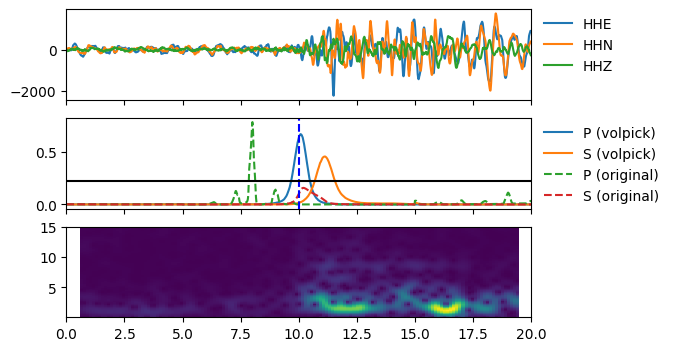

In [206]:
idx = np.random.default_rng().choice(len(test_task), 1)[0]
# idx = 1894
print(idx)
row = test_task.iloc[idx]
st = read(mseed_dir / row["trace_name_original"])
#

annotations = vol_eqt2.annotate(st, copy=True)  # , overlap=4500, blinding=[1000, 1000]
annotations2 = org_eqt2.annotate(st, copy=True)  # , overlap=4500, blinding=[1000, 1000]

st.filter("bandpass", freqmin=1, freqmax=25)
fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
ref_time = min([x.stats.starttime for x in st])
t1, t2 = 50, 70
st.trim(starttime=ref_time + t1, endtime=ref_time + t2)
annotations.trim(starttime=ref_time + t1, endtime=ref_time + t2)
annotations2.trim(starttime=ref_time + t1, endtime=ref_time + t2)
ref_time = ref_time + t1
for i in range(len(st)):
    axs[0].plot(st[i].times(reftime=ref_time), st[i].data, label=st[i].stats.channel)
axs[0].legend(
    loc="upper left", bbox_to_anchor=(1.0, 0.55, 0.2, 0.5), frameon=False, fontsize=10
)
for i in range(3):
    if (annotations[i].stats.channel.split("_")[-1] != "Detection") and (
        annotations[i].stats.channel.split("_")[-1] != "N"
    ):  # Do not plot noise curve
        axs[1].plot(
            annotations[i].times(reftime=ref_time),
            annotations[i].data,
            label=annotations[i].stats.channel.split("_")[-1] + " (volpick)",
        )

for i in range(3):
    if (annotations2[i].stats.channel.split("_")[-1] != "Detection") and (
        annotations2[i].stats.channel.split("_")[-1] != "N"
    ):  # Do not plot noise curve
        axs[1].plot(
            annotations2[i].times(reftime=ref_time),
            annotations2[i].data,
            ls="--",
            label=annotations2[i].stats.channel.split("_")[-1] + " (original)",
        )
if pd.notna(row["trace_s_arrival_sample"]):
    axs[1].axvline(row["trace_s_arrival_sample"] / 100 - t1, color="red", ls="--")
if pd.notna(row["trace_p_arrival_sample"]):
    axs[1].axvline(row["trace_p_arrival_sample"] / 100 - t1, color="blue", ls="--")
axs[1].axhline(0.22, color="black")
axs[1].legend(
    loc="upper left", bbox_to_anchor=(1.0, 0.55, 0.2, 0.5), frameon=False, fontsize=10
)
st[-1].spectrogram(axes=axs[2])
axs[2].set_ylim(0.1, 15)
# axs[1].set_xlim([t1, 70])

# Threshold

Data

In [52]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/VCSEIS_whole_train")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev", "test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

In [54]:
print(dataset.train())
print(dataset.dev())
print(dataset.test())

Unnamed dataset - 321990 traces
Unnamed dataset - 18624 traces
Unnamed dataset - 0 traces


In [56]:
print(len(dataset))

340614


In [57]:
18624 / (18624 + 321990)

0.05467772904225898

In [3]:
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
print("Number of traces in the test set and the development set:")
print(f"{len(dataset_lp_and_noise)} lp and noise traces")
print(f"{len(dataset_rg_and_noise)} vt and noise traces")

print(f"""{len(dataset.metadata[dataset.metadata["source_type"]=="lp"])} lp traces""")
print(
    f"""{len(dataset.metadata[(dataset.metadata["source_type"]!="lp")&(dataset.metadata["source_type"]!="noise")])} regular earthquake traces"""
)
print(
    f"""{len(dataset.metadata[dataset.metadata["source_type"]=="noise"])} noise earthquake traces"""
)

# full data set
targets_path_lp_and_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/all"
)
try:
    targets_path_lp_and_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg} exists")

# LP and noise
targets_path_lp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise"
)
try:
    targets_path_lp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp} exists")

# VT and noise
targets_path_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise"
)
try:
    targets_path_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg} exists")

Preloading waveforms: 100%|██████████| 52864/52864 [00:09<00:00, 5474.31it/s] 


Number of traces in the test set and the development set:
30168 lp and noise traces
30235 vt and noise traces
22629 lp traces
22696 regular earthquake traces
7539 noise earthquake traces
/home/zhongyiyuan/volpick/model_training/Eval_targets/all exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise exists


In [6]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_onephase")
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

['p', 'e']

In [7]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

# for model_dirname in model_dirs:
model_path = Path("/home/zhongyiyuan/volpick/model_training/weights_onephase/p")
pl_model = load_best_model_from_base_dir(model_path, plot_loss=False)
model = pl_model.model
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"{model_path.name}",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_onephase",
        # prob_thres=np.array([0.27,0.3,0.32]),
        # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
        prob_thres=np.arange(0.12, 0.42, 0.01),
        num_workers=32,
        batchsize=2048,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["dev"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Eval_onephase/all_pred/task0/p exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 322845.91it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100



In [14]:
def collect_task0_results_dev(
    pred_dir: Path,
    output_fname: str = "task0_metrics_sum_dev.csv",
    parse_exp_name: bool = True,
) -> pd.DataFrame:
    exp_names = [
        x
        for x in pred_dir.iterdir()
        if x.is_dir() and x.name != "task123" and (x / "dev_metrics.csv").exists()
    ]
    # print(exp_names)
    metrics_data = []
    for exp_dir in exp_names:
        print(exp_dir.name)
        stats = opt_prob_metrics_dev(exp_dir)
        # det_stats = parse_task0_detection(exp_dir, only_dev=True)
        # stats.update(det_stats)
        metrics_data.append(stats)

    df = pd.DataFrame(metrics_data)
    df.sort_values(by=["tp_thre"], ignore_index=True, inplace=True)

    if parse_exp_name:
        # model_names = {"ve": "voleqtransformer", "e": "eqtransformer", "p": "phasenet"}
        model_names = {"e": "eqtransformer", "p": "phasenet"}
        df.insert(
            1, "model", df["exp_name"].apply(lambda x: model_names[x.split("_")[0]])
        )
        df.insert(
            2, "training_fraction", df["exp_name"].apply(lambda x: x.split("_")[1][4:])
        )

    df.sort_values(by=["model", "training_fraction"], ignore_index=True, inplace=True)
    df.to_csv(pred_dir / output_fname, index=False)
    return df

In [15]:
# root_save_dir = Path(
#     "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0"
# )
root_save_dir = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_onephase/all_pred/task0"
)
stats_list = []
for pred_dir in root_save_dir.iterdir():
    if pred_dir.is_dir():
        print(pred_dir)
        stats = opt_prob_metrics_dev(pred_dir)
        stats_list.append(stats)
df = pd.DataFrame(stats_list)

/home/zhongyiyuan/volpick/model_training/Eval_onephase/all_pred/task0/p


In [16]:
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,p,0.5,0.31,0.32,13860.0,1284.0,1330.0,0.915214,0.912442,0.913826,...,0.319455,0.319451,0.173073,0.06,0.000253,0.0,0.194585,0.194577,0.113962,0.06


In [20]:
df[["dev_p_F1score", "dev_s_F1score"]]

,dev_p_F1score,dev_s_F1score
0,0.913826,0.879944


In [12]:
# root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Eval_onephase")

# pred_dirs = [root_save_dir / f"{x.name}_pred" for x in target_path_list]
# for pred_dir in pred_dirs:
#     print(pred_dir / "task0")
#     collect_task0_results_diff_training_sizes_dev(pred_dir / "task0")

# df0 = pd.read_csv(root_save_dir / "all_pred/task0/task0_metrics_sum_dev.csv")

/home/zhongyiyuan/volpick/model_training/Eval_onephase/all_pred/task0
p


IndexError: list index out of range